## 1 图像分类数据集
Fashion-MNIST是Zalando制作的数据集 - 由60,000个示例的训练集和10,000个示例的测试集组成。

每个示例都是28x28灰度图像，与10个类别的标签相关联。

Fashion-MNIST和原始MNIST数据集具有相同的图像大小和训练和测试分割的结构。

原始的MNIST数据集包含许多手写数字。通常是研究人员尝试的第一个数据集。
但也有一些缺点:
MNIST太容易了。卷积网络在MNIST上可达到99.7％。经典的机器学习算法也可以轻松实现97％。
MNIST被过度使用
MNIST不能代表现代计算机图像识别任务
更多信息请查看https://github.com/zalandoresearch/fashion-mnist

In [17]:
import math
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import d2l
from Timer import Timer
d2l.use_svg_display() #使用svg显示图片 清晰度更高?

### 读取数据集
通过内置函数datasets.FashionMNIST()将数据集下载并读取到内存中

In [20]:
# 通过ToTenser()这个类 将图像数据从PIL类型转为浮点型的tensor类型,并除以255使得所有的像素数值均在0-1之间(归一化)  #需要下载将download改为True
trans = [transforms.ToTensor()]  # 实例化对象
trans = transforms.Compose(trans)
mnist_train = torchvision.datasets.FashionMNIST(root="./data", train=True, transform=trans, download=False)
mnist_test = torchvision.datasets.FashionMNIST(root="./data", train=False, transform=trans, download=False)

In [8]:
len(mnist_train),len(mnist_test) # 60000 ,10000

(60000, 10000)

In [13]:
mnist_train[0][0].shape # 单通道 28*28的图片   mnist_train[0]表示第一张图片 mnist_train[0][0]表示图片的像素内容 mnist_train[0][1]表示图片的labels对应的标签如下面函数

torch.Size([1, 28, 28])

Fashion-MNIST中包含的10个类别，分别为t-shirt（T恤）、trouser（裤子）、pullover（套衫）、dress（连衣裙）、coat（外套）、sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和ankle boot（短靴）。
 以下函数用于在数字标签索引及其文本名称之间进行转换。

In [3]:
def get_fashion_mnist_labels(labels):
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [4]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """绘制图像列表,支持tensor和PIL"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

In [ ]:
# 看看图片长什么样子
X ,y = next(iter(data.DataLoader(mnist_train,batch_size=18)))
show_images(X.reshape(18,28,28),2,9,get_fashion_mnist_labels(y))

In [ ]:
batch_size = 256
num_workers = 4 # 设置读取图片的进程数量 小于cpu的核心数

timer = Timer()
for i in range(1,256,8):
    batch_size = i
    train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=num_workers)
    for X,y in train_iter:
        pass
    print(f"加载耗时:{timer.stop():.2f}s")
    timer.start()
pass

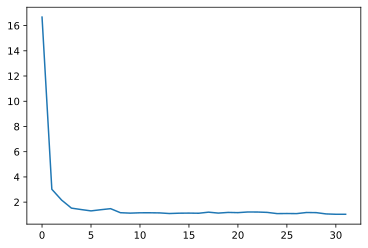

In [20]:
from matplotlib import pyplot as plt
x = list(range(len(timer.times)))
plt.plot(x,timer.times)

### softmax回归从0开始实现

In [1]:
import torch
from IPython import display
import d2l
from softmax底层 import loadFashionMnistData
batch_size = 256
train_iter,test_iter = loadFashionMnistData(batch_size)

/Users/zane/miniforge3/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


数据集加载成功 60000 10000


每张图像都是28*28的分辨率 通道数为1 需要将每张图片展平为长度为784的向量
数据集共有是个类别 所以输出的维度是10

In [15]:
num_inputs = 784
num_outputs = 10

# 初始化权重
W = torch.normal(0, .01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

矩阵X 的求和

In [5]:
X = torch.tensor([
    [1.0, 2.0, 3.0],
    [4.0, 5.0, 6.0],
])

In [6]:
X.sum() # tensor(21.) = 1+2+3+4+5+6

tensor(21.)

In [7]:
X.sum(0, keepdim=True)

tensor([[5., 7., 9.]])

In [8]:
X.sum(1, keepdim=True)

tensor([[ 6.],
        [15.]])

In [3]:
def softmax(x):
    """
    求得所有的x的softmax值
    :param x:
    :return:
    """
    X_exp = torch.exp(x)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition

In [5]:
def sm_net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)


根据索引从y_hat中取出概率
例如想从y_hat的第一行取出第0个元素  从第二行取出第2个元素

In [6]:
index = torch.tensor([0, 2])
y_hat = torch.tensor([[.1, .3, .6],
                      [.3, .2, .5]])
y_hat[[0, 1], index] # [0, 1]表示axis=0 index表示axis=1

tensor([0.1000, 0.5000])

上述写法和下述写法相同

In [19]:
x = 0
for i in index:
    print(y_hat[x][i])
    x += 1

tensor(0.1000)
tensor(0.5000)


### 实现交叉熵损失函数

In [7]:
def cross_entropy(y_hat, y):
    """计算交叉熵"""
    return -torch.log(y_hat[range(len(y_hat)), y])
# cross_entropy(y_hat,index)

### 将预测类别与真实的y进行比较

In [8]:
def num_correct(y_hat, y):
    """
    返回正确的数量
    :param y_hat:
    :param y:
    :return:
    """
    y_hat_shape = y_hat.shape
    dim_y_hat = len(y_hat_shape)
    num_y_hat = y_hat_shape[1]
    if dim_y_hat > 1 and num_y_hat > 1:
        y_hat = y_hat.argmax(axis=1)
    y_dtype = y.dtype
    y_hat_type = y_hat.type(y_dtype)  # 格式转换
    cmp = y_hat_type == y
    return cmp.type(torch.int).sum()

### 评估任意网络的准确率

In [9]:
class Accumulator:
    '''在n个变量上累加'''

    def __init__(self, n):
        self.data = [.0] * n

    def add(self, *args):
        # 添加数据
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        # 归零
        self.data = [.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def net_accuracy(net, data_iter):
    """
    测试模型的准确率
    :param net:
    :param data_iter:
    :return:
    """
    if isinstance(net, torch.nn.Module):
        # 判断net是不是nn的一个模块 如果是 将网络设置为评估模式 告诉其不要计算梯度了 只用计算准确率
        net.eval()

    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(num_correct(net(X), y), y.numel())
    return metric[0] / metric[1]

In [17]:
net_accuracy(sm_net, test_iter)

0.1343

In [31]:
def train_epoch(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()  #设置为训练模式
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(
                float(l.sum()) * len(y),
                num_correct(y_hat, y),
                y.size().numel()
            )
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(
                float(l.sum()) * len(y),
                num_correct(y_hat, y),
                y.size().numel()
            )
        return metric[0] / metric[2], metric[1] / metric[2]

In [34]:
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None, ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        self.config_axes = lambda: d2l.set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

### 训练函数

In [27]:
def train(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[.3, .9],
                        legend=['train_loss', 'train_acc', 'test_acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater)
        test_acc = net_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))

    train_loss, train_acc = train_metrics
    assert train_loss < .5, train_loss
    assert 1 >= train_acc > .7, train_acc
    assert 1 >= test_acc > 0.7, test_acc

In [ ]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)


In [ ]:
num_epochs = 10
train(sm_net, train_iter, test_iter, cross_entropy, num_epochs, updater)

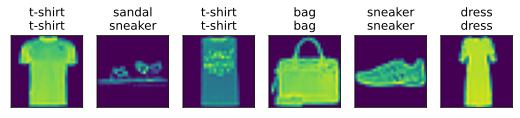

In [38]:
def predict(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])


predict(sm_net, test_iter)

AssertionError: 82.73

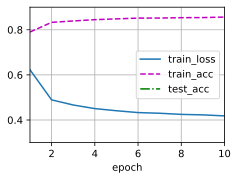

In [1]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import d2l
from Timer import Timer
from IPython import display


class Accumulator:
    '''在n个变量上累加'''

    def __init__(self, n):
        self.data = [.0] * n

    def add(self, *args):
        num = 0
        for arg in args:
            self.data[num] += float(arg)
            num += 1
        # 添加数据
        # self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        # 归零
        self.data = [.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


class sm_net:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.count_times = 0

    def count(self, X):
        # self.count_times += 1
        # print(self.count_times)
        return softmax(torch.matmul(X.reshape(-1, self.W.shape[0]), self.W) + self.b)


class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None, ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        self.config_axes = lambda: d2l.set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


def loadFashionMnistData(batch_size, resize=None):
    """
    下载FashionMnist数据集并加载到内存中
    :param batch_size:
    :param resize:
    :return:返回训练集和测试集的DataLoader
    """
    # 通过ToTenser()这个类 将图像数据从PIL类型转为浮点型的tensor类型,并除以255使得所有的像素数值均在0-1之间(归一化)  #需要下载将download改为True
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="./data", train=True, transform=trans, download=False)
    mnist_test = torchvision.datasets.FashionMNIST(root="./data", train=False, transform=trans, download=False)
    print("数据集加载成功", len(mnist_train), len(mnist_test))  # 60000 ,10000

    num_workers = 4  # 设置读取图片的进程数量 小于cpu的核心数
    return (data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=num_workers),
            data.DataLoader(mnist_test, batch_size, shuffle=True, num_workers=num_workers))


def get_fashion_mnist_labels(labels):
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]


def softmax(x):
    """
    求得所有的x的softmax值
    :param x:计算的矩阵
    :return: 返回每个位置的比例
    """
    X_exp = torch.exp(x)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition


def cross_entropy(y_hat, y):
    """计算交叉熵"""
    return -torch.log(y_hat[range(len(y_hat)), y])


def num_correct(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return cmp.type(torch.int).sum()


def net_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        # 判断net是不是nn的一个模块 如果是 将网络设置为评估模式 告诉其不要计算梯度了 只用计算准确率
        net.eval()

    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(num_correct(net.count(X), y), y.numel())
    return float(metric[0]) * 100 / metric[1]

@profile
def train_epoch(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()  # 设置为训练模式
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net.count(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
        else:
            l.sum().backward()
            updater(net, X.shape[0])
        metric.add(
            float(l.sum()),
            num_correct(y_hat, y),
            y.numel()
        )
    return metric[0] / metric[2], metric[1] / metric[2]


def train(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[.3, .9],
                        legend=['train_loss', 'train_acc', 'test_acc'])
    for epoch in range(num_epochs):
        print(('*' * 10 + str(epoch + 1) + '*' * 10).center(50))
        train_metrics = train_epoch(net, train_iter, loss, updater)
        test_acc = net_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))

    train_loss, train_acc = train_metrics
    # assert train_loss < .5, train_loss
    # assert 1 >= train_acc > .7, train_acc
    # assert 1 >= test_acc > 0.7, test_acc


def updater(net, batch_size):
    return d2l.sgd([net.W, net.b], lr, batch_size)


def predict(net, test_iter, n=6):  # @save
    """预测标签"""
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net.count(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])


if __name__ == '__main__':
    batch_size = 64
    # 加载数据集
    train_iter, test_iter = loadFashionMnistData(batch_size)

    num_inputs = 784
    num_outputs = 10
    lr = 0.1

    # 初始化权重
    W = torch.normal(0, .01, size=(num_inputs, num_outputs), requires_grad=True)
    b = torch.zeros(num_outputs, requires_grad=True)

    num_epochs = 10
    net = sm_net(W, b)
    # 开始训练网络
    train(net, train_iter, test_iter, cross_entropy, num_epochs, updater)
    # 预测
    predict(net, test_iter)
    pass

## Softmax框架实现

In [2]:
import torch
from torch import nn
import d2l
import softmax底层

batch_size = 256
train_iter,test_iter = softmax底层.loadFashionMnistData(batch_size)

/Users/zane/miniforge3/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


数据集加载成功 60000 10000


### softmax是一个单层的全连接层

In [3]:
# torch不会隐式地调整输入的形状 例如从28*28转至1*784 因此 我们需要在线性层前通过定义展平层 flatten()来调整网络的输入形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))
loss = nn.CrossEntropyLoss()

初始化权重

In [4]:
def init_weights(module):
    if type(module) == nn.Linear:
        nn.init.normal_(module.weight, std=.1)

In [5]:
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

In [ ]:
trainer = torch.optim.SGD(net.parameters(), lr=.1)

In [ ]:
epochs =10
softmax底层.train(net,train_iter,test_iter,loss,epochs,trainer)